# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14171994517769288990
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3074966937635348268
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 17:55:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'Xception'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_Xception_None S_Xception_imagenet T_Xception_None T_Xception_imagenet


['S_Xception_imagenet',
 'S_Xception_None',
 'T_Xception_imagenet',
 'T_Xception_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

Error: Failed to create the directory.
Error: Failed to create the directory.
Error: Failed to create the directory.
Error: Failed to create the directory.


# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


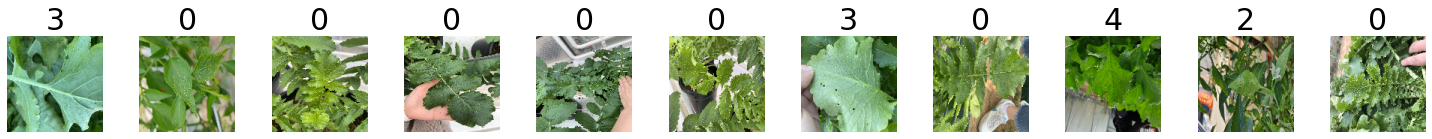

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


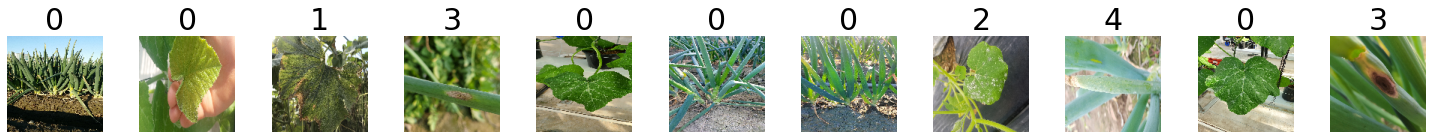

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 23s 298ms/step - loss: 1.0265 - accuracy: 0.5836 - val_loss: 1.5966 - val_accuracy: 0.2111
Epoch 2/100
36/36 [==============================] - 9s 252ms/step - loss: 0.7310 - accuracy: 0.7150 - val_loss: 1.5943 - val_accuracy: 0.3958
Epoch 3/100
36/36 [==============================] - 9s 247ms/step - loss: 0.5691 - accuracy: 0.7779 - val_loss: 1.5719 - val_accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 9s 247ms/step - loss: 0.5419 - accuracy: 0.8034 - val_loss: 1.5596 - val_accuracy: 0.3958
Epoch 5/100
36/36 [==============================] - 9s 247ms/step - loss: 0.4761 - accuracy: 0.8210 - val_loss: 1.5517 - val_accuracy: 0.2111
Epoch 6/100
36/36 [==============================] - 9s 247ms/step - loss: 0.3541 - accuracy: 0.8610 - val_loss: 1.5257 - val_accuracy: 0.2111
Epoch 7/100
36/36 [==============================] - 9s 248ms/step - loss: 0.3161 - accuracy: 0.8628 - val_loss: 1.6244 - val_accuracy: 0.211

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.026545,0.583553,1.596570,0.211082
1,0.731030,0.715040,1.594286,0.395778
2,0.569074,0.777924,1.571911,0.395778
3,0.541880,0.803430,1.559614,0.395778
4,0.476058,0.821020,1.551697,0.211082
...,...,...,...,...
75,0.013110,0.996482,0.935184,0.829815
76,0.009547,0.997801,0.971120,0.827177
77,0.012647,0.995163,2.191476,0.601583
78,0.009225,0.996042,1.076092,0.777045


Minimum validation loss: 0.8059917688369751
Maximum validation accuracy: 0.8496042490005493


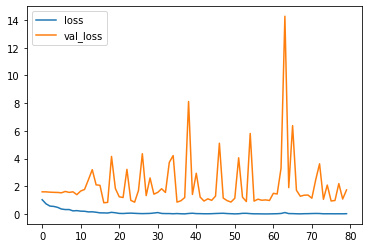

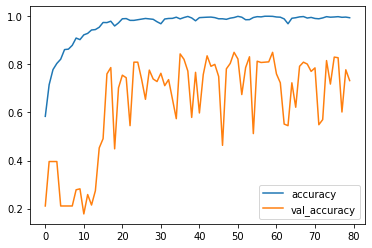

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 34ms/step - loss: 0.9103 - accuracy: 0.8391
test loss, test acc: [0.9103034138679504, 0.8390501141548157]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 26ms/step


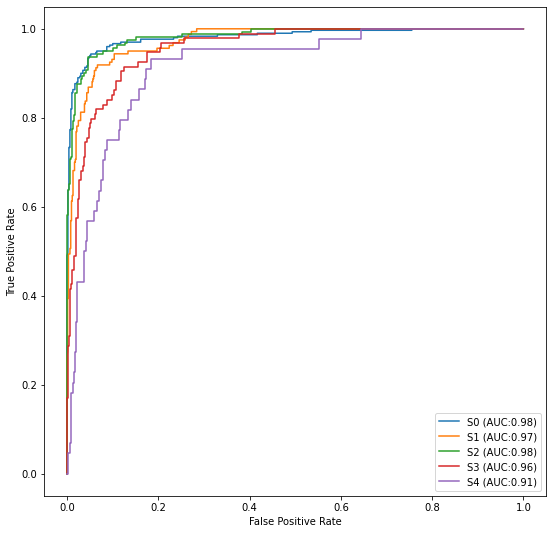

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

83697664/83683744 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 14s 275ms/step - loss: 0.5455 - accuracy: 0.7964 - val_loss: 3.1141 - val_accuracy: 0.5356
Epoch 2/100
36/36 [==============================] - 9s 250ms/step - loss: 0.2115 - accuracy: 0.9235 - val_loss: 7.0051 - val_accuracy: 0.5369
Epoch 3/100
36/36 [==============================] - 9s 250ms/step - loss: 0.1424 - accuracy: 0.9534 - val_loss: 1.7303 - val_accuracy: 0.6108
Epoch 4/100
36/36 [==============================] - 9s 250ms/step - loss: 0.1191 - accuracy: 0.9635 - val_loss: 0.7959 - val_accuracy: 0.8166
Epoch 5/100
36/36 [==============================] - 9s 247ms/step - loss: 0.1304 - accuracy: 0.9578 - val_loss: 1.1175 - val_accuracy: 0.7322
Epoch 6/100
36/36 [==============================] - 9s 250ms/step - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.6140 - val_accuracy: 0.8786
Epoch 7/100
36/36 [==============================] - 9s 247ms/step - loss: 0.1156 - accuracy: 0.9657 - val_loss: 1.1041 - val_accuracy: 0.763

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.545508,0.796394,3.114133,0.535620
1,0.211546,0.923483,7.005136,0.536939
2,0.142390,0.953386,1.730294,0.610818
3,0.119137,0.963500,0.795895,0.816623
4,0.130412,0.957784,1.117510,0.732190
5,0.063445,0.980211,0.614002,0.878628
6,0.115628,0.965699,1.104080,0.763852
7,0.099568,0.967898,1.488189,0.821900
8,0.094362,0.969657,0.409673,0.882586
9,0.046436,0.985488,1.143154,0.845646


Minimum validation loss: 0.21840210258960724
Maximum validation accuracy: 0.9353561997413635


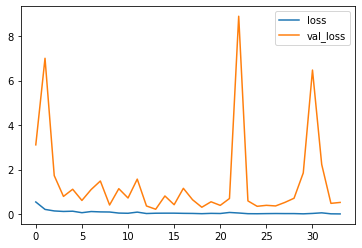

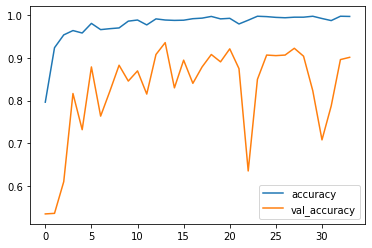

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 29ms/step - loss: 0.2759 - accuracy: 0.9195
test loss, test acc: [0.2758762240409851, 0.9195250868797302]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 26ms/step


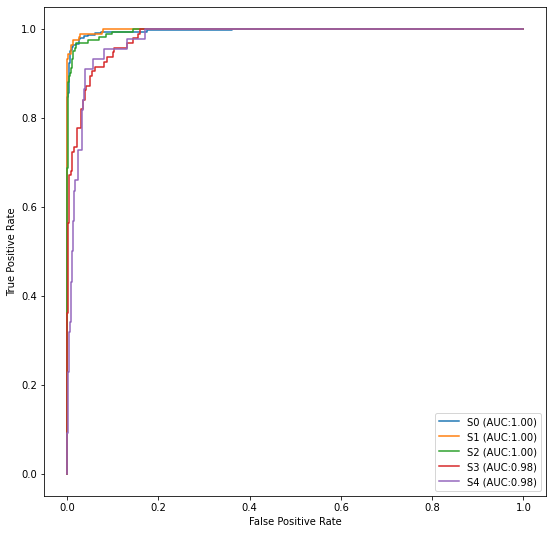

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 13s 301ms/step - loss: 0.7941 - accuracy: 0.6947 - val_loss: 1.6082 - val_accuracy: 0.1386
Epoch 2/100
32/32 [==============================] - 8s 249ms/step - loss: 0.4289 - accuracy: 0.8540 - val_loss: 1.6099 - val_accuracy: 0.1386
Epoch 3/100
32/32 [==============================] - 8s 249ms/step - loss: 0.3442 - accuracy: 0.8702 - val_loss: 1.6150 - val_accuracy: 0.1386
Epoch 4/100
32/32 [==============================] - 8s 249ms/step - loss: 0.2667 - accuracy: 0.8972 - val_loss: 1.6414 - val_accuracy: 0.1386
Epoch 5/100
32/32 [==============================] - 8s 250ms/step - loss: 0.2634 - accuracy: 0.8879 - val_loss: 1.6664 - val_accuracy: 0.1386
Epoch 6/100
32/32 [==============================] - 8s 253ms/step - loss: 0.2152 - accuracy: 0.9174 - val_loss: 1.7854 - val_accuracy: 0.1770
Epoch 7/100
32/32 [==============================] - 8s 250ms/step - loss: 0.1341 - accuracy: 0.9538 - val_loss: 1.8814 - val_accuracy: 0.177

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.794098,0.694690,1.608219,0.138643
1,0.428872,0.853982,1.609915,0.138643
2,0.344215,0.870206,1.614981,0.138643
3,0.266741,0.897247,1.641424,0.138643
4,0.263397,0.887906,1.666421,0.138643
...,...,...,...,...
71,0.015315,0.994100,1.310698,0.812684
72,0.009319,0.997542,0.581310,0.895280
73,0.006371,0.997542,0.251691,0.943953
74,0.003124,0.998525,0.293486,0.930678


Minimum validation loss: 0.14944344758987427
Maximum validation accuracy: 0.9719763994216919


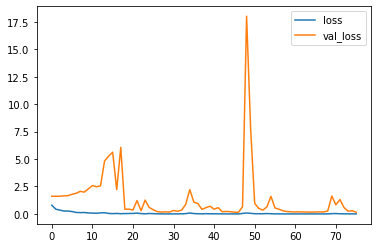

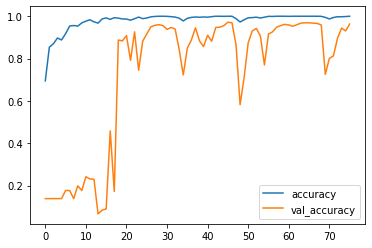

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 33ms/step - loss: 0.1675 - accuracy: 0.9676
test loss, test acc: [0.16748301684856415, 0.9675516486167908]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 26ms/step


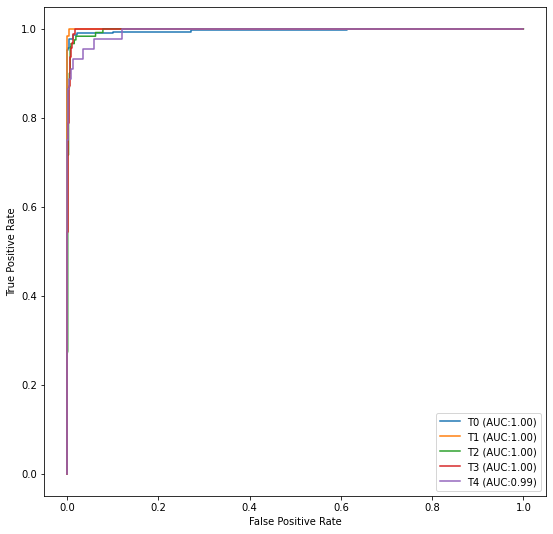

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 13s 279ms/step - loss: 0.4905 - accuracy: 0.8353 - val_loss: 2.3212 - val_accuracy: 0.8392
Epoch 2/100
32/32 [==============================] - 8s 249ms/step - loss: 0.1611 - accuracy: 0.9562 - val_loss: 2.5463 - val_accuracy: 0.7050
Epoch 3/100
32/32 [==============================] - 8s 249ms/step - loss: 0.0844 - accuracy: 0.9779 - val_loss: 2.3606 - val_accuracy: 0.8363
Epoch 4/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0571 - accuracy: 0.9818 - val_loss: 0.3506 - val_accuracy: 0.9440
Epoch 5/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0499 - accuracy: 0.9862 - val_loss: 0.4717 - val_accuracy: 0.9484
Epoch 6/100
32/32 [==============================] - 8s 249ms/step - loss: 0.0620 - accuracy: 0.9828 - val_loss: 0.7014 - val_accuracy: 0.9100
Epoch 7/100
32/32 [==============================] - 8s 249ms/step - loss: 0.0500 - accuracy: 0.9862 - val_loss: 5.3316 - val_accuracy: 0.703

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.490533,0.835300,2.321226,0.839233
1,0.161114,0.956244,2.546268,0.705015
2,0.084377,0.977876,2.360635,0.836283
3,0.057105,0.981809,0.350577,0.943953
4,0.049948,0.986234,0.471741,0.948378
5,0.061984,0.982793,0.701376,0.910029
6,0.049960,0.986234,5.331611,0.703540
7,0.021492,0.991642,0.233881,0.942478
8,0.028629,0.990659,0.219317,0.970501
9,0.009109,0.996558,0.114200,0.958702


Minimum validation loss: 0.01881619729101658
Maximum validation accuracy: 0.9941002726554871


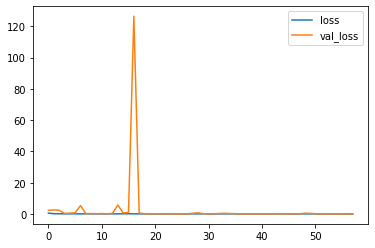

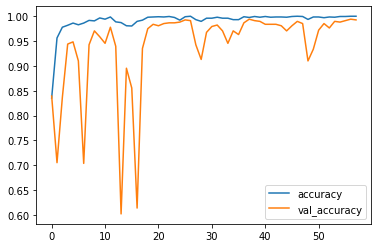

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 28ms/step - loss: 0.0799 - accuracy: 0.9882
test loss, test acc: [0.07989499717950821, 0.9882006049156189]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 26ms/step


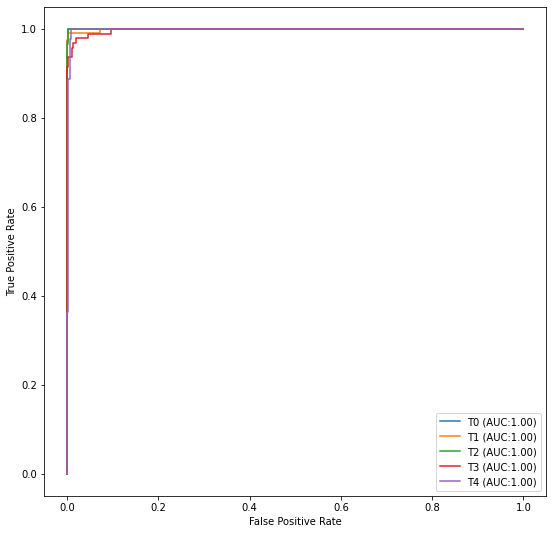

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_Xception_None
test loss, test acc: [0.9103034138679504, 0.8390501141548157]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_Xception_imagenet
test loss, test acc: [0.2758762240409851, 0.9195250868797302]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_Xception_None
test loss, test acc: [0.16748301684856415, 0.9675516486167908]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_Xception_imagenet
test loss, test acc: [0.07989499717950821, 0.9882006049156189]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_Xception_None →→→ Target Test
22/22 [==============================] - 1s 28ms/step - loss: 6.9095 - accuracy: 0.2788
test loss, test acc: [6.909460544586182, 0.2787610590457916]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_Xception_imagenet →→→ Target Test
22/22 [==============================] - 1s 28ms/step - loss: 4.3714 - accuracy: 0.2139
test loss, test acc: [4.371444225311279, 0.2138643115758896]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_Xception_None →→→ Source Test
24/24 [==============================] - 1s 29ms/step - loss: 5.5510 - accuracy: 0.3047
test loss, test acc: [5.55101203918457, 0.30474933981895447]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_Xception_imagenet →→→ Source Test
24/24 [==============================] - 1s 28ms/step - loss: 4.6269 - accuracy: 0.2414
test loss, test acc: [4.62693452835083, 0.2414247989654541]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
